# NBA Player Performance Trend Analysis
**By Sibhi Sakthivel**

# 1) Introduction

Even the best athletes in the world have an off night eventually, sometimes even a few bad games in a row.

# 2) Research Question

In this study, we are going to be designing, executing, and sharing my findings on trends in NBA player scoring performances. Specifically, we are going to be addressing the question:

**Do sustained departures from a player’s long-term scoring expectation correlate with an increased likelihood of subsequent over- or under-performance relative to that expectation?**

In other words, we are analyzing whether a period of consecutive games with poor scoring performances is correlated with a higher chance of an upcoming game exceeding baseline scoring performance, and vice versa.

# 3) Context, Assumptions, and Confounding Factors

NBA player performance is influenced by several factors, including opponent matchup and teammate availability. These two factors can have a significant impact on a player's efficiency, usage, and minutes played, which can influence how well a player plays and the statistics they record.

Because opponent strength and lineup composition are not randomly assigned, they represent potential confounding variables when analyzing short-term performance trends. Apparent performance “reversion” or “continuation” may reflect changes in these factors rather than intrinsic performance dynamics. For this reason, the analysis proceeds in stages. Initial results examine the raw relationship between sustained performance deviations and subsequent outcomes, followed by conditioned analyses that explicitly account for matchup difficulty and teammate availability to assess robustness.

This analysis is observational and does not attempt to establish causal effects. Instead, it aims to evaluate whether commonly cited performance narratives retain predictive or descriptive value once key contextual factors are considered.

# 3) Data Overview

### Unit of Analysis

The primary unit of analysis in this study is a player–game observation, where each row represents an individual player’s scoring performance in a single NBA game.

### Data Source

The dataset was constructed from the publicly available NBA API, in which we retrieved game-level data including player box score statistics, game context variables, teammate availability, and opponent matchup metrics.

### Data Scope

The analysis focuses on regular-season games from the 2024–25 NBA season, with players required to meet minimum participation thresholds to ensure stable baseline estimates.

For clarity and interpretability, this study focuses exclusively on player scoring performance, measured using points scored per game. While player performance is multi-dimensional, scoring provides a clear, widely understood outcome that aligns with common performance narratives and decision-making contexts.

Additionally, the analysis is conducted at the individual player level, using a single high-usage player as a case study. This design choice allows for detailed examination of performance dynamics without conflating effects across heterogeneous player roles, play styles, and usage profiles.

While this limits the generalizability of results, the framework is designed to be extensible to additional players and performance metrics in future work.

### Data Limitations

Several limitations are inherent in the dataset. Defensive matchup difficulty is represented using team-level and positional defensive metrics, which serve as coarse proxies and do not capture individual on-ball defensive assignments or in-game matchup adjustments.

Teammate availability is approximated using minutes-based thresholds, where high-usage teammates are considered “available” if they play at least a fixed proportion of their season-average minutes. While this approach captures major role-level changes, it may not fully reflect partial usage restrictions, staggered rotations, or in-game context that affects effective player involvement.

In [1]:
# Connect to database
from sqlalchemy import create_engine
import pandas as pd

DB_USER = "admin"
DB_PASSWORD = "admin"
DB_HOST = "localhost"
DB_PORT = 5433
DB_NAME = "nba_db"

engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

# Player box score data
pbs = pd.read_sql(
    """
    SELECT *
    FROM boxscores.player_boxscores_traditional_v3
    """,
    engine
)

# Team box score data
tbs = pd.read_sql(
    """
    SELECT *
    FROM boxscores.league_gamelogs
    """,
    engine
)

print(pbs.columns, tbs.columns)

Index(['game_id_api', 'team_id', 'team_city', 'team_name', 'team_tricode',
       'team_slug', 'player_id', 'first_name', 'family_name', 'name_initial',
       'player_slug', 'position', 'comment', 'jersey_number', 'minutes_raw',
       'field_goals_made', 'field_goals_attempted', 'field_goals_percentage',
       'three_pointers_made', 'three_pointers_attempted',
       'three_pointers_percentage', 'free_throws_made',
       'free_throws_attempted', 'free_throws_percentage', 'rebounds_offensive',
       'rebounds_defensive', 'rebounds_total', 'assists', 'steals', 'blocks',
       'turnovers', 'fouls_personal', 'points', 'plus_minus_points', 'game_id',
       'minutes_decimal', 'player_name', 'clean_name'],
      dtype='object') Index(['season_id', 'team_id', 'team_abbreviation', 'team_name', 'game_id',
       'game_date_raw', 'matchup', 'wl', 'minutes_raw', 'field_goals_made',
       'field_goals_attempted', 'field_goals_percentage',
       'three_pointers_made', 'three_pointers_attemp

# 4) Methodology

### Baseline Scoring Performance

A player’s baseline scoring performance is defined as their season-average points per game across all regular-season games played up to a given point in the season. This baseline is intended to represent a player’s long-term expected scoring output under typical conditions, abstracting away short-term variance and game-to-game noise.

By anchoring performance deviations to a long-term expectation, the analysis focuses on whether sustained departures from expected scoring levels are associated with short-term reversion or continuation in subsequent games.

Rolling-window baselines were considered but not used in order to avoid conflating short-term form with long-term expectation, which is central to the research question.

### Performance Deviation

For each game, a player’s performance deviation is defined as the difference between their observed scoring output in that game and their season-average scoring baseline. This deviation represents how much a player over- or under-performed relative to their long-term expected scoring level.

Positive deviations indicate games in which the player scored more points than their season average, while negative deviations indicate games in which the player scored fewer points than expected. By preserving the direction of the deviation, this definition allows performance to be evaluated not only in terms of magnitude but also in terms of whether a player exceeded or fell short of their baseline expectation.

This measure serves as the fundamental building block for identifying sustained periods of over- or under-performance across consecutive games, which are examined in subsequent sections.

### Sustained Performance Streaks

Each game is first classified as an overperformance or underperformance based on whether the player’s scoring output exceeds or falls below their season-average baseline. Using this classification, a sustained performance streak is defined as a sequence of consecutive games in which the player consistently overperforms or underperforms relative to baseline.

In this study, a streak is considered to occur when a player records at least three consecutive overperforming or underperforming games. The length of the streak corresponds to the number of consecutive games meeting this criterion. This framework allows performance trends to be represented as discrete states that can be used to evaluate how the likelihood of subsequent over- or underperformance changes as streak length increases.

### Outcome Definition

The primary outcome of interest is the player’s scoring performance in the game immediately following a sustained performance streak. For each identified streak, the subsequent game is classified based on whether the player’s scoring output exceeds or falls below their season-average baseline.

This outcome is represented as a binary indicator, where an overperformance corresponds to scoring above baseline and an underperformance corresponds to scoring below baseline. This formulation allows the probability of over- or underperformance in the next game to be estimated conditional on the length and direction of the preceding streak.

### Contextual Adjustments

Opponent difficulty is represented using team-level defensive metrics, which serve as coarse proxies for overall matchup strength. These measures are used to stratify analyses and assess whether observed performance relationships persist across varying levels of opponent defensive quality.

Teammate availability is approximated using minutes-based thresholds. High-usage teammates are considered available in a given game if they play at least a fixed proportion of their season-average minutes. This approach is intended to capture major role-level shifts while remaining interpretable and reproducible.

These contextual variables are not used to redefine performance baselines or streaks, but are incorporated in subsequent analyses to evaluate whether observed performance patterns are robust to changes in game context.

# 5) Analysis



### Dataset Construction

We'll begin by constructing a dataset from the database that include all the data types we'll be using in this analysis. These data types include:
- Game date/ID
- Player name/ID
- Team name/ID
- Player points scored
- Player season average points
- Player point deviation from season average
- Scoring performance over/under season average flag

The final game of the season is excluded from conditional probability calculations since no subsequent outcome exists.f

In [2]:
query = open("sql/dataset_construction.sql").read()
df = pd.read_sql(query, engine)

jamal_murray = df[df["player_name"] == "Jamal Murray"]
jamal_murray.head()

,game_id,game_date,player_id,player_name,clean_name,team_id,pts,season_avg_pts,deviation,over_flag,team_abbreviation,opp_pts_allowed
6980,0022400075,2024-10-24,1627750,Jamal Murray,jamal murray,1610612743,12,NaN,NaN,0,OKC,NaN
6981,0022400087,2024-10-26,1627750,Jamal Murray,jamal murray,1610612743,22,12.00,10.00,1,LAC,102.00
6982,0022400107,2024-10-28,1627750,Jamal Murray,jamal murray,1610612743,17,17.00,0.00,0,TOR,105.50
6983,0022400113,2024-10-29,1627750,Jamal Murray,jamal murray,1610612743,24,17.00,7.00,1,BKN,112.00
6984,0022400139,2024-11-01,1627750,Jamal Murray,jamal murray,1610612743,6,18.75,-12.75,0,MIN,118.75


### Feature Validation & Sanity Checks

Now we'll perform some checks to verify that variables are logical and correctly represent what they are intended to.

(67, 12)
1    67
Name: count, dtype: int64
True
      pts  season_avg_pts  opp_pts_allowed
6980   12             NaN              NaN
6981   22            12.0            102.0
6982   17            17.0            105.5
       game_date  pts  season_avg_pts  deviation
7043  2025-03-24   28       21.587302   6.412698
6989  2024-11-19   27       17.333333   9.666667
7034  2025-03-05   24       21.388889   2.611111
True    67
Name: count, dtype: int64


<Axes: title={'center': 'Season Average Points Over Time'}, xlabel='game_date'>

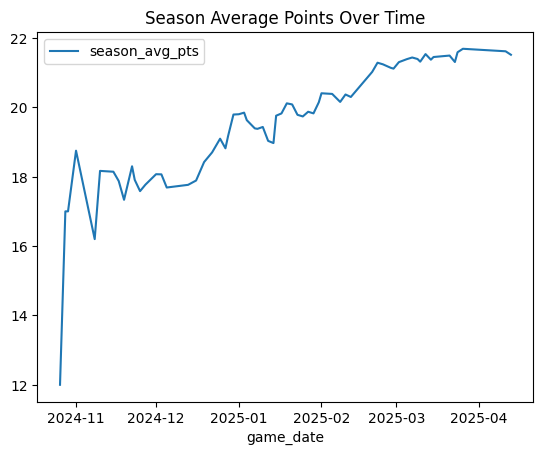

In [3]:
print(jamal_murray.shape)       # number of games played, number of cols in df
print(jamal_murray.groupby(     # number of player_id - game_id combos = number of games played
    ["player_id", "game_id"]).size().value_counts()) 

print(jamal_murray["game_date"].is_monotonic_increasing)                # game dates are ordered correctly
print(jamal_murray.head(3)[["pts", "season_avg_pts", "opp_pts_allowed"]])  # first row has point averages

jamal_murray["deviation"].describe()    # mean is about 0, 

print(jamal_murray.sample(3)[["game_date", "pts", "season_avg_pts", "deviation"]]) # deviation correctly calculated

print((
    (jamal_murray["pts"] > jamal_murray["season_avg_pts"])
    == (jamal_murray["over_flag"] == 1)
).value_counts())

import matplotlib.pyplot as plt

jamal_murray[["game_date", "season_avg_pts"]].plot(
    x="game_date",
    y="season_avg_pts",
    title="Season Average Points Over Time"
)

### Exploratory Data Analysis

First let's observe the distribution of deviations throughout the season.

Text(0.5, 1.0, 'Point Deviation from Season Baseline Over Time')

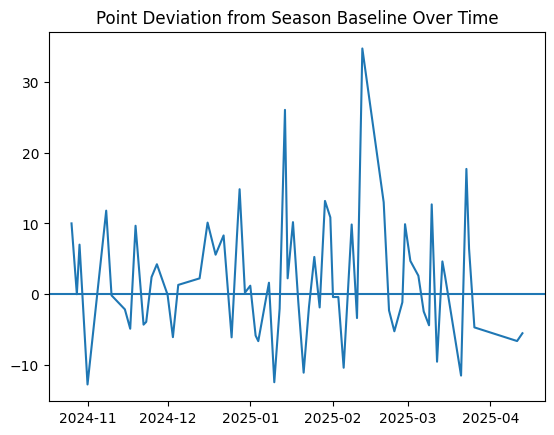

In [4]:
plt.figure()
plt.plot(jamal_murray["game_date"], jamal_murray["deviation"])
plt.axhline(0)
plt.title("Point Deviation from Season Baseline Over Time")

Now let's look into how the season average points scored changes throughout the season.

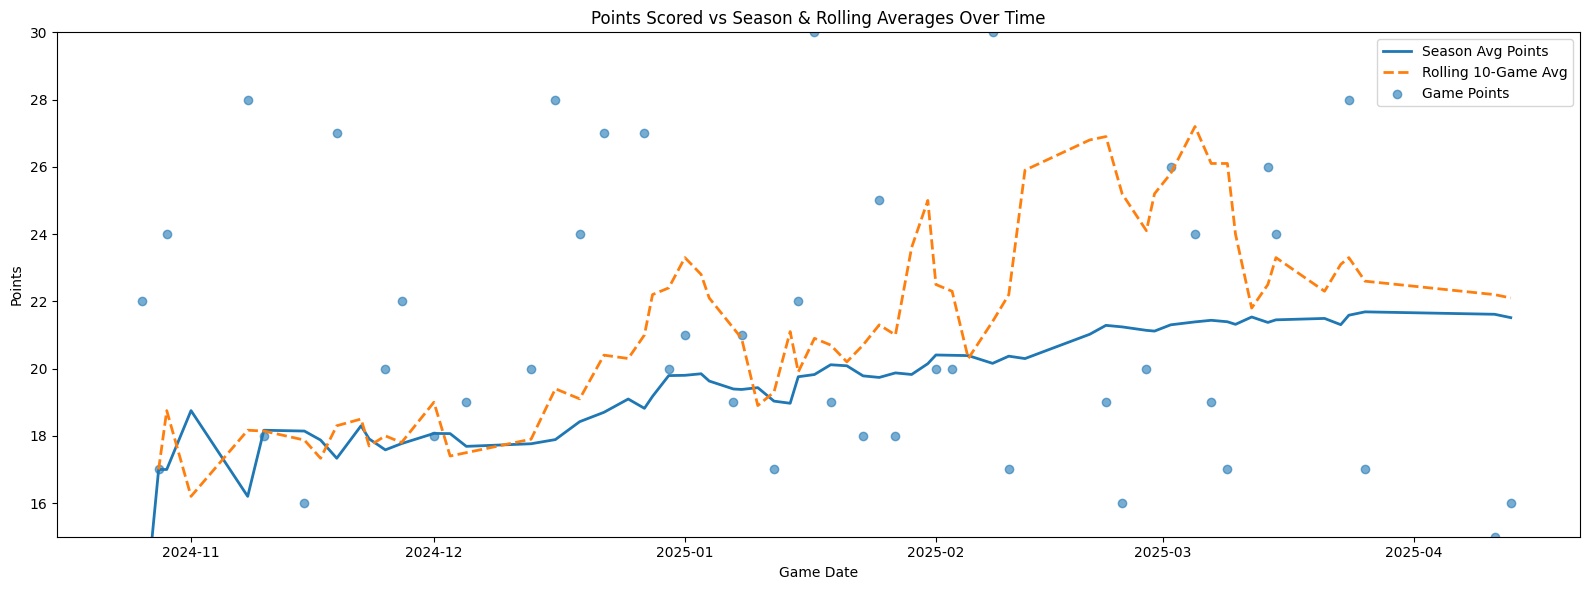

In [5]:
import matplotlib.pyplot as plt

# Ensure data is sorted correctly
analysis_dataset = jamal_murray.sort_values("game_date")

# Rolling average (10-game)
analysis_dataset["rolling_10_pts"] = (
    analysis_dataset["pts"]
    .rolling(window=10, min_periods=3)
    .mean()
)

# Plot
plt.figure(figsize=(16, 6))

# Season cumulative average
plt.plot(
    analysis_dataset["game_date"],
    analysis_dataset["season_avg_pts"],
    label="Season Avg Points",
    linewidth=2
)

# Rolling 10-game average
plt.plot(
    analysis_dataset["game_date"],
    analysis_dataset["rolling_10_pts"],
    label="Rolling 10-Game Avg",
    linewidth=2,
    linestyle="--"
)

# Actual game points
plt.scatter(
    analysis_dataset["game_date"],
    analysis_dataset["pts"],
    label="Game Points",
    alpha=0.6
)

# Formatting
plt.ylim(15, 30)
plt.xlabel("Game Date")
plt.ylabel("Points")
plt.title("Points Scored vs Season & Rolling Averages Over Time")
plt.legend()
plt.tight_layout()

plt.show()


In [6]:
early = analysis_dataset.head(15)["pts"].mean()
late = analysis_dataset.tail(15)["pts"].mean()

early, late


(np.float64(18.066666666666666), np.float64(22.533333333333335))

Now let's take a look at lengths of streaks where scoring is either over or under the season average points.

In [7]:
# ============================================
# Compute Over / Under Performance Streaks
# ============================================

# Ensure data is ordered correctly
analysis_dataset = (
    analysis_dataset
    .sort_values("game_date")
    .reset_index(drop=True)
)

# --------------------------------------------
# Step 1: Identify where a streak changes
# A new streak starts whenever over_flag
# differs from the previous game
# --------------------------------------------
analysis_dataset["streak_id"] = (
    analysis_dataset["over_flag"]
    .ne(analysis_dataset["over_flag"].shift())
    .cumsum()
)

# --------------------------------------------
# Step 2: Compute streak length within each run
# cumcount() gives 0,1,2,... so we add 1
# --------------------------------------------
analysis_dataset["streak_length"] = (
    analysis_dataset
    .groupby("streak_id")
    .cumcount()
    .add(1)
)

# --------------------------------------------
# Step 3: Signed streaks (optional but useful)
# Positive = over-performance streak
# Negative = under-performance streak
# --------------------------------------------
analysis_dataset["signed_streak"] = (
    analysis_dataset["streak_length"]
    * analysis_dataset["over_flag"].replace({0: -1})
)

# --------------------------------------------
# Sanity check: inspect early rows
# --------------------------------------------
analysis_dataset[
    ["game_date", "pts", "season_avg_pts", "over_flag", "streak_length", "signed_streak"]
].head(12)


,game_date,pts,season_avg_pts,over_flag,streak_length,signed_streak
0,2024-10-24,12,NaN,0,1,-1
1,2024-10-26,22,12.000000,1,1,1
2,2024-10-28,17,17.000000,0,1,-1
3,2024-10-29,24,17.000000,1,1,1
4,2024-11-01,6,18.750000,0,1,-1
5,2024-11-08,28,16.200000,1,1,1
6,2024-11-10,18,18.166667,0,1,-1
7,2024-11-15,16,18.142857,0,2,-2
8,2024-11-17,13,17.875000,0,3,-3
9,2024-11-19,27,17.333333,1,1,1


In [8]:
# ============================================
# Compute Next-Game Outcome & Conditional Probabilities
# ============================================

# Ensure correct ordering (important)
analysis_dataset = (
    analysis_dataset
    .sort_values("game_date")
    .reset_index(drop=True)
)

# --------------------------------------------
# Step 1: Next-game over/under outcome
# shift(-1) pulls the NEXT game's result
# --------------------------------------------
analysis_dataset["next_over_flag"] = (
    analysis_dataset["over_flag"].shift(-1)
)

# Drop final row (no next game exists)
analysis_for_probs = analysis_dataset.dropna(subset=["next_over_flag"])

# --------------------------------------------
# Step 2: Compute P(over | signed_streak)
# Mean of binary variable = probability
# --------------------------------------------
prob_table = (
    analysis_for_probs
    .groupby("signed_streak")["next_over_flag"]
    .agg(
        prob_over="mean",
        n="count"
    )
    .reset_index()
    .sort_values("signed_streak")
)

print(f"""overall prob_over = {analysis_dataset["over_flag"].mean()}""")
prob_table


overall prob_over = 0.4925373134328358


,signed_streak,prob_over,n
0,-3,1.000000,5
1,-2,0.400000,10
2,-1,0.444444,18
3,1,0.529412,17
4,2,0.444444,9
5,3,0.500000,4
6,4,0.500000,2
7,5,0.000000,1


The table above shows that...

Below we only show streaks that have at least 5 occurrences to remove sparse streak events and show that the pattern still holds when we exclude these events.

In [9]:
df = prob_table[prob_table["n"] >= 5]
df

,signed_streak,prob_over,n
0,-3,1.000000,5
1,-2,0.400000,10
2,-1,0.444444,18
3,1,0.529412,17
4,2,0.444444,9


While extreme streak lengths show volatile probabilities due to small sample sizes, the regression-to-mean effect persists for streak lengths with n ≥ 5, suggesting the result is not driven by sparse edge cases.

Now we'll perform a few validation tests to observe whether these findings are consistent under various conditions. Before we do that, we need to recreate the base dataset because we've already calculated rolling season averages and streak lengths under default conditions, but since we are going to be altering these conditions in the following tests, we will need to recompute values accordingly.

In [10]:
base = """
WITH teams AS(
    SELECT 
        "TEAM_ID" AS team_id, 
        "TEAM_ABBREVIATION" AS team, 
        "GAME_ID" AS game_id,
        "GAME_DATE" AS game_date, 
        "MATCHUP" AS matchup, 
        "PTS" AS pts,
        AVG("PTS") OVER (
            PARTITION BY RIGHT("MATCHUP", 3)
            ORDER BY "GAME_DATE" ASC
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS opp_pts_allowed
    FROM team_box_scores.league_gamelog t
)

SELECT 
    t.game_id,
    t.game_date,
    p."personId" AS player_id,
    CONCAT_WS(' ', p."firstName", p."familyName") AS player_name,
    p."teamId" AS team_id,
    RIGHT(t.matchup, 3) AS team,
    p.points AS pts,
    LEFT(t.matchup, 3) AS opp,
    t.opp_pts_allowed,
    t.matchup
FROM teams t
JOIN player_box_scores.player_boxscores p
    ON p."teamId" <> t.team_id
        AND p."gameId" = t.game_id
ORDER BY player_id, game_date ASC
"""

analytic_base = pd.read_sql(base, engine)
analytic_base.head()

ProgrammingError: (psycopg2.errors.UndefinedTable) relation "team_box_scores.league_gamelog" does not exist
LINE 15:     FROM team_box_scores.league_gamelog t
                  ^

[SQL: 
WITH teams AS(
    SELECT 
        "TEAM_ID" AS team_id, 
        "TEAM_ABBREVIATION" AS team, 
        "GAME_ID" AS game_id,
        "GAME_DATE" AS game_date, 
        "MATCHUP" AS matchup, 
        "PTS" AS pts,
        AVG("PTS") OVER (
            PARTITION BY RIGHT("MATCHUP", 3)
            ORDER BY "GAME_DATE" ASC
            ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
        ) AS opp_pts_allowed
    FROM team_box_scores.league_gamelog t
)

SELECT 
    t.game_id,
    t.game_date,
    p."personId" AS player_id,
    CONCAT_WS(' ', p."firstName", p."familyName") AS player_name,
    p."teamId" AS team_id,
    RIGHT(t.matchup, 3) AS team,
    p.points AS pts,
    LEFT(t.matchup, 3) AS opp,
    t.opp_pts_allowed,
    t.matchup
FROM teams t
JOIN player_box_scores.player_boxscores p
    ON p."teamId" <> t.team_id
        AND p."gameId" = t.game_id
ORDER BY player_id, game_date ASC
]
(Background on this error at: https://sqlalche.me/e/20/f405)

Now we'll verify that this pattern holds on a smaller subsets of the dataset, starting with the first half of the season.

In [ ]:
murray = (
    analytic_base[analytic_base["player_name"] == "Jamal Murray"]
    .sort_values("game_date")
    .reset_index(drop=True)
)

# Rolling season average points
murray["szn_avg_pts"] = (
    murray["pts"]
    .expanding()
    .mean()
    .shift(1)
)

# Scoring deviations from season average
murray["deviation"] = murray["pts"] - murray["szn_avg_pts"]

# Over/Under Flag
murray["over_flag"] = (murray["deviation"] > 0).astype(int)

# Streak ID - group together games from a streak
murray["streak_id"] = (
    murray["over_flag"]
    .ne(murray["over_flag"].shift())    # if change in over/under flag between consecutive games
    .cumsum()                           # increment streak id 
)

# Streak length
murray["streak_length"] = (
    murray
    .groupby("streak_id")
    .cumcount()
    .add(1)
)

# Signed streak (positive = over, negative = under)
murray["signed_streak"] = (
    murray["streak_length"]
    * murray["over_flag"].replace({0: -1})
)

# Next game over/under flag
murray["next_over_flag"] = murray["over_flag"].shift(-1)

murray_early_season = murray[:34]
murray_early_season = (
    murray_early_season
    .dropna(subset=["next_over_flag"])
    .groupby("signed_streak")["next_over_flag"]
    .agg(prob_over="mean", n="count")
    .reset_index()
)
murray_early_season


In [ ]:
murray_late_season = murray[34:]
murray_late_season = (
    murray_late_season
    .dropna(subset=["next_over_flag"])
    .groupby("signed_streak")["next_over_flag"]
    .agg(prob_over="mean", n="count")
    .reset_index()
)
murray_late_season

Now let's separate home and away games to see if the observed pattern still holds.

In [ ]:
murray_home = murray[murray["is_home"] == True]

Now we'll see how probabilities shift when we change the definition of baseline performance to the rolling 10-game point average.

Now we'll see how probabilities shift when we only flag games that are +/- 2 points from baseline performance.